# The *Perfect* Fit
  With this Notebook I will be extracting data with the Foursquare API and scrapping RentHop.com for average rent for one bedroom apartments. Once all data is obtained, it will be cleaned and processed by city, by neighborhood. This will utilize the k-means clustering algorithm to further choose between which city is my personal best fit and will contribute to neighborhood decisions as well. 

In [1]:
import numpy as np                          # library to handle data in a vectorized manner
import pandas as pd                         # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json                                 # library to handle JSON files
from geopy.geocoders import Nominatim       # convert an address into latitude and longitude values
import requests                             # library to handle requests
from pandas.io.json import json_normalize   # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium                               # map rendering library

%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Downloading Datasets for each city
  New York City - This data is the same as the week 3's "Segmenting and Clustering Neighborhoods" data  
    
  Boston - https://data.boston.gov/dataset/boston-neighborhoods/resource/13ee2b65-6547-4168-b112-83995f138602 geojson data of Boston's neighborhoods  
    
  Chicago - https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9 geojson data of Chicago's neighborhoods

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    print("New York JSON data loaded")

with open('Boston_Neighborhoods.json') as json_data:
    boston_data = json.load(json_data)
    print("Boston JSON data loaded")

with open('Chicago_Neighborhoods.json') as json_data:
    chicago_data = json.load(json_data)
    print("Chicago JSON data loaded")

nyc_neighborhoods_data = newyork_data['features']
bos_neighborhoods_data = boston_data['features']
chi_neighborhoods_data = chicago_data['features']

New York JSON data loaded
Boston JSON data loaded
Chicago JSON data loaded


### Transform into pandas df

In [3]:
nyc_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
bos_names = ['Neighborhood', 'Latitude', 'Longitude']
chi_names = ['Neighborhood', 'Secondary Neighborhood', 'Latitude', 'Longitude']

nyc_hoods = pd.DataFrame(columns=nyc_names)
bos_hoods = pd.DataFrame(columns=bos_names)
chi_hoods = pd.DataFrame(columns=chi_names)

### If the JSON files were all configured the same...
  ~~hoods = ny_hoods, bos_hoods, chi_hoods  
  for hood in hoods:~~

In [4]:
# Loop for New York City Data
for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_hoods = nyc_hoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
# Loop for Boston Data
for data in bos_neighborhoods_data:
    neighborhood_name = data["properties"]["Name"]
    address = neighborhood_name + ", MA"

    geolocator = Nominatim(user_agent="bos_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except AttributeError:
        pass
    #print('The geograpical coordinate of {} are {}, {}.'.format(neighborhood_name, latitude, longitude))
    bos_hoods = bos_hoods.append({'Neighborhood': neighborhood_name,
                                  'Latitude': latitude,
                                  'Longitude': longitude}, ignore_index=True)

In [6]:
nyc_hoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
# Manually fixing specific neighborhoods
### Leather District
bos_hoods.loc[[5], ["Latitude"]] = 42.3505
bos_hoods.loc[[5], ["Longitude"]] = -71.0579

### Harbor Islands
bos_hoods.loc[[25], ["Latitude"]] = 42.3167
bos_hoods.loc[[25], ["Longitude"]] = -70.9681

### South Boston Waterfront
bos_hoods.loc[[22], ["Latitude"]] = 42.3483
bos_hoods.loc[[22], ["Longitude"]] = -71.0428

### Downtown
bos_hoods.loc[[15], ["Latitude"]] = 42.3557
bos_hoods.loc[[15], ["Longitude"]] = -71.0572

bos_hoods.head()

,Neighborhood,Latitude,Longitude
0,Roslindale,42.291209,-71.124497
1,Jamaica Plain,42.309820,-71.120330
2,Mission Hill,42.332560,-71.103608
3,Longwood,42.341718,-71.109922
4,Bay Village,42.350011,-71.066948


In [8]:
for data in chi_neighborhoods_data:
    primary_name = data["properties"]["pri_neigh"]
    secondary_name = data["properties"]["sec_neigh"].title()
    address = primary_name + ", Chicago"

    geolocator = Nominatim(user_agent="chi_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except AttributeError:
        pass
    #print('The geograpical coordinate of {} are {}, {}.'.format(primary_name, latitude, longitude))
    chi_hoods = chi_hoods.append({'Neighborhood': primary_name,
                                  'Secondary Neighborhood': secondary_name,
                                  'Latitude': latitude,
                                  'Longitude': longitude}, ignore_index=True)

In [9]:
# Manually fixing specific neighborhoods
### River North
chi_hoods.loc[[32], ["Latitude"]] = 41.8924
chi_hoods.loc[[32], ["Longitude"]] = -87.6341

### Musuem Campus 
chi_hoods.loc[[97], ["Latitude"]] = 41.8636
chi_hoods.loc[[97], ["Longitude"]] = -87.6163

chi_hoods.head()

,Neighborhood,Secondary Neighborhood,Latitude,Longitude
0,Grand Boulevard,Bronzeville,41.813923,-87.617272
1,Printers Row,Printers Row,41.873787,-87.628900
2,United Center,United Center,41.880683,-87.674185
3,Sheffield & DePaul,Sheffield & Depaul,41.880683,-87.674185
4,Humboldt Park,Humboldt Park,41.905767,-87.704174


### Creating Maps of each city

In [10]:
address = ['New York City, NY', "Boston, MA", "Chicago, IL"]
city_dict = {}
for city in address:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    city_dict[city] = [latitude, longitude]
    print('The geograpical coordinate of {} are {}, {}.'.format(city, latitude, longitude))

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.
The geograpical coordinate of Boston, MA are 42.3602534, -71.0582912.
The geograpical coordinate of Chicago, IL are 41.8755616, -87.6244212.


In [11]:
# create map of New York using latitude and longitude values
#map_newyork = folium.Map(location=city_dict['New York City, NY'], zoom_start=10)

# add markers to map
#for lat, lng, borough, neighborhood in zip(nyc_hoods['Latitude'], nyc_hoods['Longitude'], nyc_hoods['Borough'], nyc_hoods['Neighborhood']):
#    label = '{}, {}'.format(neighborhood, borough)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=5,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='#3186cc',
#        fill_opacity=0.7,
#        parse_html=False).add_to(map_newyork)  

#map_newyork

In [12]:
# create map of Boston using latitude and longitude values
#map_boston = folium.Map(location=city_dict['Boston, MA'], zoom_start=12)

# add markers to map
#for lat, lng, neighborhood in zip(bos_hoods['Latitude'], bos_hoods['Longitude'], bos_hoods['Neighborhood']):
#    label = '{}'.format(neighborhood)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=5,
#        popup=label,
#        color='green',
#        fill=True,
#        fill_color='#90ee90',
#        fill_opacity=0.7,
#        parse_html=False).add_to(map_boston)  

#map_boston

In [13]:
# create map of Chicago using latitude and longitude values
#map_chicago = folium.Map(location=city_dict['Chicago, IL'], zoom_start=10)

# add markers to map

#for lat, lng, borough, neighborhood in zip(chi_hoods['Latitude'], chi_hoods['Longitude'], chi_hoods['Secondary Neighborhood'], chi_hoods['Neighborhood']):
#    label = '{}, {}'.format(neighborhood, borough)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=5,
#        popup=label,
#        color='red',
#        fill=True,
#        fill_color='#E62020',
#        fill_opacity=0.35,
#        parse_html=False).add_to(map_chicago)  

#map_chicago

In [107]:
# create map of United States using latitude and longitude values
map_usa = folium.Map(location=[42, -79], zoom_start=6)

for lat, lng, borough, neighborhood in zip(nyc_hoods['Latitude'], nyc_hoods['Longitude'], nyc_hoods['Borough'], nyc_hoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa) 

for lat, lng, neighborhood in zip(bos_hoods['Latitude'], bos_hoods['Longitude'], bos_hoods['Neighborhood']):
    label = '{}, Boston'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#50c878',
        fill=True,
        fill_color='#90ee90',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  

for lat, lng, neighborhood in zip(chi_hoods['Latitude'], chi_hoods['Longitude'], chi_hoods['Neighborhood']):
    label = '{}, Chicago'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#E62020',
        fill_opacity=0.35,
        parse_html=False).add_to(map_usa)  

map_usa

# Using Foursquare API to Categorize each neighborhood

### Defining Foursquare Credientials

In [15]:
CLIENT_ID = 'GNZ1Q222RCBIGH1JROMBBDG54HVDWGSTYKARWOIV2S3M2H1R' # your Foursquare ID
CLIENT_SECRET = 'H0YAPWYAUDS0OTC0XFHPWKFPY5RZCFMP1N3ZRFF0YYGUZZEL' # your Foursquare Secret
VERSION = '20200723' # Foursquare API version
LIMIT = 50 # limit of number of venues returned by Foursquare API

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GNZ1Q222RCBIGH1JROMBBDG54HVDWGSTYKARWOIV2S3M2H1R
CLIENT_SECRET:H0YAPWYAUDS0OTC0XFHPWKFPY5RZCFMP1N3ZRFF0YYGUZZEL


## Venues Function
   With this function, venues throughout all three cities will be captured

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Obtaining Venues for all neighborhoods

In [59]:
try:
    nyc_venues = getNearbyVenues(names=nyc_hoods['Neighborhood'],
                                 latitudes=nyc_hoods['Latitude'],
                                 longitudes=nyc_hoods['Longitude']
                                  )
except KeyError:
    pass

print("\n All NYC Neighborhoods Analyzed! \n")

try:
    bos_venues = getNearbyVenues(names=bos_hoods['Neighborhood'],
                                 latitudes=bos_hoods['Latitude'],
                                 longitudes=bos_hoods['Longitude']
                                 )
except KeyError:
    pass

print("\n All BOS Neighborhoods Analyzed! \n")

try:
    chi_venues = getNearbyVenues(names=chi_hoods['Neighborhood'],
                             latitudes=chi_hoods['Latitude'],
                             longitudes=chi_hoods['Longitude']
                             )
except KeyError:
    pass

print("\n All CHI Neighborhoods Analyzed! \n")

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

### Inspecting Data to see how it was formatted

In [18]:
print(nyc_venues.shape)
print(nyc_venues.nunique())
nyc_venues.head()

(7843, 7)
Neighborhood               301
Neighborhood Latitude      305
Neighborhood Longitude     305
Venue                     6239
Venue Latitude            7549
Venue Longitude           7545
Venue Category             411
dtype: int64


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


In [19]:
print(bos_venues.shape)
print(bos_venues.nunique())
bos_venues.head()

(871, 7)
Neighborhood               24
Neighborhood Latitude      24
Neighborhood Longitude     24
Venue                     718
Venue Latitude            799
Venue Longitude           799
Venue Category            188
dtype: int64


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roslindale,42.291209,-71.124497,Peters Hill,42.293617,-71.128063,Scenic Lookout
1,Roslindale,42.291209,-71.124497,Guira Y Tambora,42.291845,-71.122254,Cuban Restaurant
2,Roslindale,42.291209,-71.124497,Roslindale House Of Pizza,42.287989,-71.126549,Pizza Place
3,Roslindale,42.291209,-71.124497,Arboretum Grill,42.291813,-71.122762,American Restaurant
4,Roslindale,42.291209,-71.124497,Target,42.288204,-71.126659,Big Box Store


In [20]:
print(chi_venues.shape)
print(chi_venues.nunique())
chi_venues.head()

(2288, 7)
Neighborhood                96
Neighborhood Latitude       90
Neighborhood Longitude      90
Venue                     1693
Venue Latitude            1940
Venue Longitude           1940
Venue Category             281
dtype: int64


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Grand Boulevard,41.813923,-87.617272,Parkway Ballroom,41.813142,-87.616064,Food
1,Grand Boulevard,41.813923,-87.617272,Ain't She Sweet Cafe,41.816817,-87.613004,Coffee Shop
2,Grand Boulevard,41.813923,-87.617272,Sip & Savor,41.816817,-87.612876,Coffee Shop
3,Grand Boulevard,41.813923,-87.617272,Peach's Restaurant,41.809481,-87.617009,Breakfast Spot
4,Grand Boulevard,41.813923,-87.617272,Blanc,41.813585,-87.616003,Art Gallery


### One Hot encoding technique

In [21]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] + ", NY"

# rows by neighborhood and by taking the mean of the frequency of occurrence of each category

nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Scul

In [22]:
# one hot encoding
bos_onehot = pd.get_dummies(bos_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bos_onehot['Neighborhood'] = bos_venues['Neighborhood'] + ", MA"

# rows by neighborhood and by taking the mean of the frequency of occurrence of each category

bos_grouped = bos_onehot.groupby('Neighborhood').mean().reset_index()
bos_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Café,Caribbean Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Nail Salon,National Park,New American Restaurant,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Ski Chalet,Smoke Shop,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Allston, MA",0.0,0.00,0.000000,0.0,0.0,0.000000,0.020000,0.00,0.0,0.0,0.0,0.060000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.02,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.00,0.02,0.000000,0.000000,0.020000,0.0,0.0,0.0,0.060000,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.02,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.02,0.02,0.02,0.00,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.04,0.02,0.00,0.0,0.0,0.0,0.02,0.00000,0.000000,0.000000,0.000000,0.02,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.02,0.000000,0.02,0.000000,0.000000,0.00000,0.02000,0.02,0.0,0.020000,0.02,0.0,0.0,0.0,0.00000,0.10000,0.00000,0.0,0.0,0.0,0.02,0.000000,0.0,0.02,0.000000,0.04000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.040000,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.020000,0.02,0.00,0.000000,0.020000,0.000000,0.0,0.020000,0.0,0.0,0.000000,0.0,0.0,0.020000,0.00,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.020000,0.0,0.02,0.000000,0.0,0.02,0.0,0.040000,0.000000,0.02,0.0,0.0,0.0,0.0,0.0,0.020000,0.020000,0.0,0.000000,0.00,0.00000
1,"Back Bay, MA",0.0,0.02,0.060000,0.0,0.0,0.000000,0.000000,0.02,0.0,0.0,0.0,0.000000,0.020000,0.000000,0.0,0.0,0.0,0.00000,0.00,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.02,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.

In [23]:
# one hot encoding
chi_onehot = pd.get_dummies(chi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chi_onehot['Neighborhood'] = chi_venues['Neighborhood'] + ", IL"

# rows by neighborhood and by taking the mean of the frequency of occurrence of each category

chi_grouped = chi_onehot.groupby('Neighborhood').mean().reset_index()
chi_grouped.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Albany

# Creating a table of all neighborhoods
  The grouped data frames are of all different shapes  
  This block intersects the three frames together

In [24]:
#Shows how many unique columns are in each frame 
# nyc_cat = set(nyc_venues["Venue Category"])
# bos_cat = set(bos_venues['Venue Category'])
# chi_cat = set(chi_venues['Venue Category'])

#Total unique column names
# cat_list = (list(nyc_cat | bos_cat | chi_cat))

#Checking work
# print(nyc_grouped.shape)
# print(bos_grouped.shape)
# print(chi_grouped.shape)
# print(len(cat_list))

#Intersecting of frames
foo = pd.concat([nyc_grouped, bos_grouped], axis=0, sort=False)
cities_grouped = pd.concat([foo, chi_grouped], axis=0, sort=False)
cities_grouped = cities_grouped.fillna(0)
print(cities_grouped.shape)
cities_grouped.head()

(421, 445)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Scul

### This function will sort venues by descending order

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [126]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cities_grouped['Neighborhood']

for ind in np.arange(cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

In [27]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Allerton, NY",Pizza Place,Deli / Bodega,Bus Station,Supermarket,Bakery,Chinese Restaurant,Breakfast Spot,Gas Station,Fried Chicken Joint,Pharmacy
1,"Annadale, NY",Pizza Place,American Restaurant,Diner,Liquor Store,Food,Restaurant,Cosmetics Shop,Bakery,Bar,Train Station
2,"Arden Heights, NY",Coffee Shop,Lawyer,Bus Stop,Pizza Place,Pharmacy,Food Court,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
3,"Arlington, NY",Bus Stop,General Entertainment,Boat or Ferry,Grocery Store,Intersection,Deli / Bodega,Fish & Chips Shop,Financial or Legal Service,Fish Market,Food Truck
4,"Arrochar, NY",Bus Stop,Deli / Bodega,Italian Restaurant,Liquor Store,Supermarket,Food Truck,Sandwich Place,Mediterranean Restaurant,Outdoors & Recreation,Bagel Shop


# Cluster Analysis

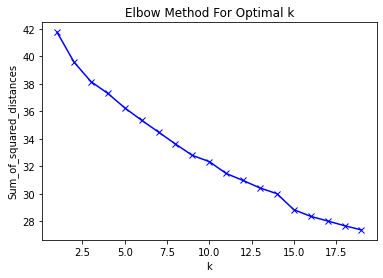

<Figure size 432x288 with 0 Axes>

In [209]:
Sum_of_squared_distances = []
kclusters = range(1,20)
for k in kclusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cities_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(kclusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.savefig('optimal_Kvalue.png')

In [124]:
# set number of clusters
kclusters = 15

cities_grouped_clustering = cities_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([11, 11, 11,  7,  7,  1, 11,  1,  1, 11])

In [127]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Split into respected cities
nyc_sub = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'].str.contains(", NY")]
bos_sub = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'].str.contains(", MA")]
chi_sub = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'].str.contains(", IL")]

# Stripping State Abbreviation
nyc_sub['Neighborhood'] = nyc_sub['Neighborhood'].map(lambda x: x.rstrip(', NY'))
bos_sub['Neighborhood'] = bos_sub['Neighborhood'].map(lambda x: x.rstrip(', MA'))
chi_sub['Neighborhood'] = chi_sub['Neighborhood'].map(lambda x: x.rstrip(', IL'))

# merge cities locations with city clusters to add latitude/longitude for each neighborhood
nyc_merged = nyc_hoods.join(nyc_sub.set_index('Neighborhood'), on='Neighborhood')
bos_merged = bos_hoods.join(bos_sub.set_index('Neighborhood'), on='Neighborhood')
chi_merged = chi_hoods.join(chi_sub.set_index('Neighborhood'), on='Neighborhood')

# Dropping neighborhoods without venues; float to int
nyc_merged.dropna(inplace=True)
nyc_merged["Cluster Labels"] = nyc_merged["Cluster Labels"].astype(int)
bos_merged.dropna(inplace=True)
bos_merged["Cluster Labels"] = bos_merged["Cluster Labels"].astype(int)
chi_merged.dropna(inplace=True)
chi_merged["Cluster Labels"] = chi_merged["Cluster Labels"].astype(int)

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,11,Pharmacy,Laundromat,Ice Cream Shop,Deli / Bodega,Sandwich Place,Donut Shop,Pizza Place,Gas Station,Dessert Shop,Japanese Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,11,Trail,Restaurant,Bus Station,Park,Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Post Office,Bagel Shop
2,Bronx,Eastchester,40.887556,-73.827806,3,Bus Station,Caribbean Restaurant,Diner,Bus Stop,Deli / Bodega,Convenience Store,Fast Food Restaurant,Platform,Pizza Place,Chinese Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,3,River,Bus Station,Plaza,Music Venue,Food Court,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market
4,Bronx,Riverdale,40.890834,-73.912585,3,Medical Supply Store,Bus Station,Park,Food Truck,Gym,Locksmith,Plaza,Bank,Fish & Chips Shop,Financial or Legal Service


# Visualize the Clusters

In [128]:
# create map
map_clusters = folium.Map(location=[42, -79], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon, poi, cluster in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['Neighborhood'], bos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon, poi, cluster in zip(chi_merged['Latitude'], chi_merged['Longitude'], chi_merged['Neighborhood'], chi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Check out the clusters

### Cluster 1

In [157]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 0].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
247,0,"Silver Lake, NY",Burger Joint,Golf Course,American Restaurant,Gym,Food Truck,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market


### Cluster 2

In [158]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 1].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,1,"Arverne, NY",Surf Spot,Sandwich Place,Metro Station,Coffee Shop,Pizza Place,Bed & Breakfast,Bus Stop,Playground,Wine Shop,Board Shop
7,1,"Astoria, NY",Seafood Restaurant,Bar,Middle Eastern Restaurant,Indian Restaurant,Greek Restaurant,Bakery,Ice Cream Shop,Dessert Shop,Mediterranean Restaurant,Gourmet Shop
8,1,"Auburndale, NY",Italian Restaurant,Korean Restaurant,Hookah Bar,Bar,Miscellaneous Shop,Fast Food Restaurant,Supermarket,Sushi Restaurant,Gymnastics Gym,Mattress Store
10,1,"Battery Park City, NY",Park,Memorial Site,Coffee Shop,Plaza,Gym,Shopping Mall,Gourmet Shop,Food Court,Hotel,Smoke Shop
11,1,"Bay Ridge, NY",Spa,Italian Restaurant,Pizza Place,Ice Cream Shop,Grocery Store,Bagel Shop,American Restaurant,Chinese Restaurant,Hookah Bar,Greek Restaurant


### Cluster 3

In [133]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 2].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,2,"Beechhurst, NY",Supermarket,Italian Restaurant,Boutique,Yoga Studio,Chinese Restaurant,Convenience Store,Pizza Place,Optical Shop,Shopping Plaza,Donut Shop
19,2,"Bellaire, NY",Bus Station,Breakfast Spot,Coffee Shop,Chinese Restaurant,Convenience Store,Gym,Italian Restaurant,Greek Restaurant,Moving Target,Deli / Bodega
20,2,"Belle Harbor, NY",Beach,Deli / Bodega,Spa,Pub,Mexican Restaurant,Boutique,Donut Shop,Pharmacy,Chinese Restaurant,Bakery
21,2,"Bellerose, NY",Deli / Bodega,Pizza Place,Italian Restaurant,Seafood Restaurant,Bank,Salon / Barbershop,Donut Shop,Pub,Playground,Chinese Restaurant
22,2,"Belmont, NY",Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Fish Market,Food & Drink Shop,Liquor Store,Diner,Martial Arts Dojo


### Cluster 4

In [134]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 3].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,3,"Broadway Junction, NY",Diner,Fried Chicken Joint,Donut Shop,Seafood Restaurant,Ice Cream Shop,Gas Station,Bus Station,Caribbean Restaurant,Nightclub,Pizza Place
37,3,"Brownsville, NY",Fried Chicken Joint,Chinese Restaurant,Moving Target,Farmers Market,Convenience Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground
41,3,"Cambria Heights, NY",Caribbean Restaurant,Nightclub,Gym / Fitness Center,Pharmacy,Flower Shop,Restaurant,Bakery,Liquor Store,Fish Market,Flea Market
54,3,"Claremont Village, NY",Bus Station,Chinese Restaurant,Grocery Store,Bakery,Deli / Bodega,Park,Liquor Store,Gift Shop,Fried Chicken Joint,Pizza Place
63,3,"Concourse Village, NY",Fast Food Restaurant,Sandwich Place,Deli / Bodega,Fried Chicken Joint,Convenience Store,Pharmacy,Mexican Restaurant,Juice Bar,Women's Store,Gym / Fitness Center


### Cluster 5

In [35]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 4].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
123,4,"Grymes Hill, NY",Dog Run,Vineyard,Food Stand,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market
142,4,"Jamaica Estates, NY",Bus Station,Dog Run,Vineyard,Food Truck,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market


### Cluster 6

In [36]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 5].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
249,5,"Somerville, NY",Park,Vineyard,Food Stand,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market
268,5,"Todt Hill, NY",Park,Vineyard,Food Stand,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market
66,5,"Norwood Park, IL",Park,Pool,History Museum,Vineyard,Food Court,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market
94,5,"Woodlawn, IL",Park,Coffee Shop,Vineyard,Food Court,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market


# Descriptive Visuals

### Total AMount of Venues in the Boston area

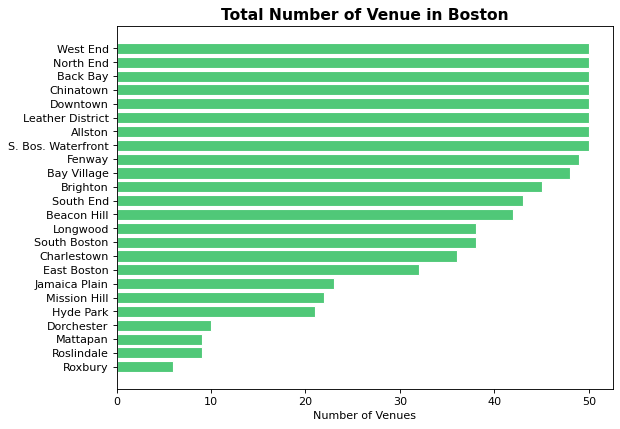

<Figure size 432x288 with 0 Axes>

In [208]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bar_bos = bos_venues.groupby(["Neighborhood"]).count()[["Venue"]].sort_values(by="Venue")
labels = list(bar_bos.index)
labels[16] = "S. Bos. Waterfront"
bars = bar_bos["Venue"]

r = np.arange(len(bars))
barWidth = 0.2
plt.barh(r, bars, color='#50c878', edgecolor='white', label=labels)
plt.xlabel("Number of Venues")
plt.yticks([r for r in range(len(bars))], labels)
plt.title("Total Number of Venue in Boston", loc = "center", fontsize=14, fontweight="bold")

plt.show()
#plt.savefig('boston_venues.png')

In [166]:
cluster1 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 0]
cluster1 = cluster1.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster2 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 1]
cluster2 = cluster2.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster3 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 2]
cluster3 = cluster3.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster4 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 3]
cluster4 = cluster4.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster5 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 4]
cluster5 = cluster5.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster6 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 5]
cluster6 = cluster6.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster7 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 6]
cluster7 = cluster7.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster8 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 7]
cluster8 = cluster8.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster9 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 8]
cluster9 = cluster9.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster10 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 9]
cluster10 = cluster10.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster11 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 10]
cluster11 = cluster11.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster12 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 11]
cluster12 = cluster12.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster13 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 12]
cluster13 = cluster13.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster14 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 13]
cluster14 = cluster14.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()

cluster15 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 14]
cluster15 = cluster15.groupby(["Cluster Labels", "1st Most Common Venue"]).count()[["Neighborhood"]].sort_values(by="Neighborhood", ascending = False).head()



In [207]:
mostcommon = pd.concat([cluster1, cluster2, cluster3, cluster4, cluster5,
                        cluster6, cluster7, cluster8, cluster9, cluster10,
                        cluster11, cluster12, cluster13, cluster14, cluster15], axis=0)
mostcommon.rename(columns={'Neighborhood': 'Count'}, inplace=True)
mostcommon.to_csv(r'C:\Users\manst\Desktop\Coursera\Coursera_Capstone\mostcommon.csv')

# Average Rent for selected city